In [1]:
import matplotlib
%matplotlib inline

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
#from scipy.special import diagamma, gamma

import seaborn as sns
sns.set()

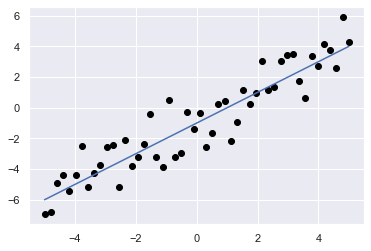

In [2]:
def model(x, weights):
    X = np.array([x**k for k in range(len(weights))]).transpose()
    return (X @ weights[:,np.newaxis]).flatten()

no_samples = 50

x = np.linspace(-5, 5, no_samples)

weights = np.array([-1, 1])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + np.random.normal(0, std_noise, len(y_true))

plt.plot(x, y_true)
plt.scatter(x, y_noisy, color='black')
plt.show()

In [3]:
def elbo():
    return (-0.5 * N * np.log(2 * np.pi) - 0.5 * (alpha * (y_noisy - X @ w_mean[:,np.newaxis])**2 + X @ w_cov @ X.T).sum() + 0.5 * np.log(np.abs(w_cov)).sum()
           + 0.5 * D - np.log(math.gamma(alpha_a_prior)) + alpha_a_prior * np.log(alpha_b_prior) - alpha_b_prior * alpha + 
           + np.log(math.gamma(alpha_a)) + alpha_a * np.log(alpha_b) + alpha_a - np.log(math.gamma(beta_c_prior)) + 
            beta_c_prior * np.log(beta_d_prior) + np.log(math.gamma(beta_c)) - beta_c * np.log(beta_d))

In [4]:
D = 2#len(weights)
N = len(y_noisy)

X = np.array([x**k for k in range(D)]).transpose()

alpha_a_prior = 10**(-3)
alpha_b_prior = 10**(3)
beta_c_prior = 10**(-2)
beta_d_prior = 10**(2)

alpha = 0.1
beta = 0.1

num_iter = 1000

alpha_a = alpha_a_prior + D/2 
beta_c = beta_c_prior + N/2

best_alpha = None
best_beta = None
best_elbo = None

elbos = []
for i in tqdm(range(num_iter)):
    # For w
    w_cov = np.linalg.inv(beta * X.T @ X + alpha * np.eye(D))
    
    w_mean = beta * w_cov @ X.T @ y_noisy
    
    #for beta
    beta_d = beta_d_prior + 0.5 * ((y_noisy - X @ w_mean) ** 2).mean() + 0.5 * alpha * w_mean.T @ w_mean
    beta = beta_c/beta_d
    
    # for alpha (shrinkage)
    alpha_b = alpha_b_prior + 0.5 * (beta * w_mean.T @ w_mean + np.trace(w_cov))
    alpha = alpha_a/alpha_b
    
    elbo_loss = elbo()
    
    if best_elbo == None or elbo_loss > best_elbo:
        best_elbo = elbo_loss
        best_alpha = alpha
        best_beta = beta
    
    elbos.append(elbo_loss)

w_cov = np.linalg.inv(X.T @ X + best_alpha * np.eye(D))
    
w_mean = w_cov @ X.T @ y_noisy
print(best_beta)
print(w_mean)
print(w_cov)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
100%|██████████| 1000/1000 [00:00<00:00, 4205.23it/s]

0.2483201662606685
[-0.89658712  1.00630372]
[[1.99995997e-02 1.63839138e-19]
 [1.63839138e-19 2.30587703e-03]]


In [5]:
preds = []
for _ in range(100):
    weight_sample = np.random.multivariate_normal(w_mean, w_cov)
    pred = X @ weight_sample[:,np.newaxis]
    preds.append(pred)
preds = np.array(preds)
std = preds.std(axis=0).flatten()
print(std.mean())

0.19103606981675683


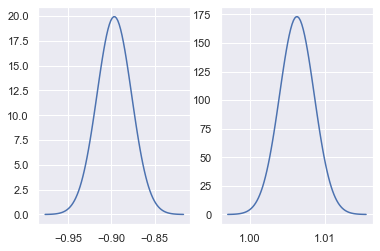

In [7]:
fig = plt.figure()
for i, w in enumerate(w_mean):
    ax = fig.add_subplot(1, len(w_mean), i+1)
    std = w_cov[i,i]
    x = np.linspace(w-4*std, w+4*std, 100)
    ax.plot(x, stats.norm.pdf(x, w, std))
plt.show()

In [ ]:
pred = (X @ w_mean[:,np.newaxis]).flatten()
pred+2*std
plt.plot(x, y_true, label='true', color='#D1895C')
plt.fill_between(x, y_true+2*std_noise, y_true-2*std_noise, color='#D1895C', alpha=0.5)
plt.plot(x, pred, label='pred')
plt.fill_between(x, pred+2*std, pred-2*std, alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.ylim([-10,10])
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(elbos)), elbos)
plt.show()